# 三层全连接神经网络实现手写数字识别

In [1]:
import os
import numpy as np
import struct
import math
import matplotlib.pyplot as plt

## 定义数据载入函数

In [2]:
class Dataloader:
    def __init__(self, root_dir):
        self.root = root_dir
        
    def load_mnist(self, x_path, y_path):
        with open(y_path, 'rb') as r:
            magic, n = struct.unpack('>II', r.read(8))
            labels = np.fromfile(r, dtype=np.uint8)
            
        with open(x_path, 'rb') as r:
            magic, num, rows, cols = struct.unpack('>IIII', r.read(16))
            images = np.fromfile(r, dtype=np.uint8).reshape(len(labels), 784)

        return images, labels
    
    def load_data(self):
        x_train, y_train = self.load_mnist(
            os.path.join(self.root, "train-images.idx3-ubyte"),
            os.path.join(self.root, "train-labels.idx1-ubyte"))
        x_test, y_test = self.load_mnist(
            os.path.join(self.root, "t10k-images.idx3-ubyte"),
            os.path.join(self.root, "t10k-labels.idx1-ubyte"))
        
        return x_train, y_train, x_test, y_test

## 全连接层

In [3]:
class Fully_Connect:
    def __init__(self, num_in, num_out):
        self.w = np.random.normal(size= (num_in, num_out), scale=0.01, loc=0)
        self.b = np.random.normal(size= num_out, scale=0.01, loc=0)
        self.x = 0
        self.y = 0
        
    def infer(self, x):
        self.x = x
        out = np.dot(self.x, self.w) + self.b
        self.y = out
        return out
    
    def Gred(self, d_p):
        d_c = np.dot(d_p, np.transpose(self.w))
        self.w = self.w - lr * np.dot(np.transpose(self.x), d_p)
        self.b = self.b - lr * d_p
        return d_c    

## 激活函数

In [4]:
class Activation:
    def __init__(self):
        self.x = 0
    
    def infer(self, x):
        self.x = x
        out = np.maximum(self.x, 0)
        return out
    
    def Gred(self, d_p):
        d_c = d_p
        p = np.isinf(self.x / self.x)
        d_c[p] = 0
        return d_c

## Softmax函数

In [5]:
class Softmax:
    def __init__(self):
        self.x = 0
        self.t = 0
        self.y = 0
        self.t_onehot = 0
    
    def infer(self, x, truth):
        self.x = x
        self.t = truth
        
        row_max = self.x.max(axis= 1)
        row_max = row_max.reshape(-1, 1)
        x = self.x - row_max
        x_exp = np.exp(x)
        x_sum = np.sum(x_exp, axis= 1, keepdims=True)
        out = x_exp / x_sum
        self.y = out
        
        return out
    
    def cal_loss(self):
        one_hot = np.zeros_like(self.y)
        one_hot[np.arange(batch), self.t] = 1.0 #one-hot code
        self.t_onehot = one_hot
        loss = - np.sum(np.log(self.y) * self.t_onehot) / batch
        
        if(loss == 'nan'):
            print(self.y)
            print(self.t_onehot)
            
        return loss
    
    def Gred(self):
        d_c = 1.0 / batch * (self.y - self.t_onehot)
        return d_c

## 定义网络

In [6]:
class Net:
    def __init__(self, in_num, num1, num2, num3):
        self.x = 0
        self.label = 0
        self.fc1 = Fully_Connect(in_num, num1)
        self.act1 = Activation()
        self.fc2 = Fully_Connect(num1, num2)
        self.act2 = Activation()
        self.fc3 = Fully_Connect(num2, num3)
        self.softmax = Softmax()
        
    def forward(self, x, label):
        f1 = self.fc1.infer(x)
        a1 = self.act1.infer(f1)
        f2 = self.fc2.infer(a1)
        a2 = self.act2.infer(f2)
        f3 = self.fc3.infer(a2) 
        res = self.softmax.infer(f3, label)
        
        loss = self.softmax.cal_loss()
        
        return loss, res
    
    def backward(self):
        loss_d = self.softmax.Gred()
        fc3_d = self.fc3.Gred(loss_d)
        act2_d =self.act2.Gred(fc3_d)
        fc2_d = self.fc2.Gred(act2_d)
        act1_d = self.act1.Gred(fc2_d)
        fc1_d = self.fc1.Gred(act1_d)    

## 定义训练函数

In [7]:
def train(net):
    loss = 0
    for e in range(epoch):
        for iter in range(math.ceil(train_images.shape[0] / batch)):
            x = train_images[iter*batch:(iter+1)*batch,:]
            label = train_labels[iter*batch:(iter+1)*batch]
            loss, res = net.forward(x, label)
            net.backward()
        loss_list.append(loss)
        print("epoch = {} loss = {}".format(e+1, loss))
    
    return net

## 绘制loss曲线图

In [8]:
def draw_loss(loss_list):
    y_axis = loss_list
    x_axis = [i for i in range(len(loss_list))]
    plt.figure(figsize=(12,6))
    plt.plot(x_axis, y_axis)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()

## 计算Accuracy

In [9]:
def evaluate(net):
    pred = np.zeros_like(test_labels)
    for iter in range(math.ceil(test_images.shape[0] / batch)):
        x = test_images[iter*batch:(iter+1)*batch,:]
        label = test_labels[iter*batch:(iter+1)*batch]
        loss, res = net.forward(x, label)
        pred_label = np.argmax(res, axis = 1)
        pred[iter*batch:(iter+1)*batch] = pred_label
        
    accuracy = np.mean(pred == test_labels)
    return accuracy

## 设置参数

In [10]:
file = "D:mnist//"
lr = 0.001
batch = 200
#im_scale = 784
epoch = 300

#500 neurons in the hidden layer1,
#300 neurons in the hidden layer2,
#10 neurons in the hidden layer3
cell_num1 = 500
cell_num2 = 300
cell_num3 = 10

loss_list = []

## 载入数据

In [11]:
dataloader = Dataloader(file)
train_images, train_labels, test_images, test_labels = dataloader.load_data()
print("训练数据尺寸\n 图像 {} 标签{}".format(train_images.shape, train_labels.shape))
print("测试数据尺寸\n 图像 {} 标签{}".format(test_images.shape, test_labels.shape))

训练数据尺寸
 图像 (60000, 784) 标签(60000,)
测试数据尺寸
 图像 (10000, 784) 标签(10000,)


## Start training and evaluating!！

epoch = 1 loss = 0.24590768669543406
epoch = 2 loss = 0.19855591120348737
epoch = 3 loss = 0.18063119853581486
epoch = 4 loss = 0.16971160933927895
epoch = 5 loss = 0.16193214241813458
epoch = 6 loss = 0.1562243737711325
epoch = 7 loss = 0.1517602721727827
epoch = 8 loss = 0.14823935949466208
epoch = 9 loss = 0.14540103122674056
epoch = 10 loss = 0.1431747230671493
epoch = 11 loss = 0.1414677926273388
epoch = 12 loss = 0.1401570543930881
epoch = 13 loss = 0.1390531604108021
epoch = 14 loss = 0.13810987494495797
epoch = 15 loss = 0.1374093767126646
epoch = 16 loss = 0.13688254483349366
epoch = 17 loss = 0.13645437722689072
epoch = 18 loss = 0.13616726908850482
epoch = 19 loss = 0.13592774347451658
epoch = 20 loss = 0.13570427340014832
epoch = 21 loss = 0.1355313050813497
epoch = 22 loss = 0.13539031735904783
epoch = 23 loss = 0.13524447104327852
epoch = 24 loss = 0.13509935914412088
epoch = 25 loss = 0.13497595355389136
epoch = 26 loss = 0.13470995905716607
epoch = 27 loss = 0.134414034

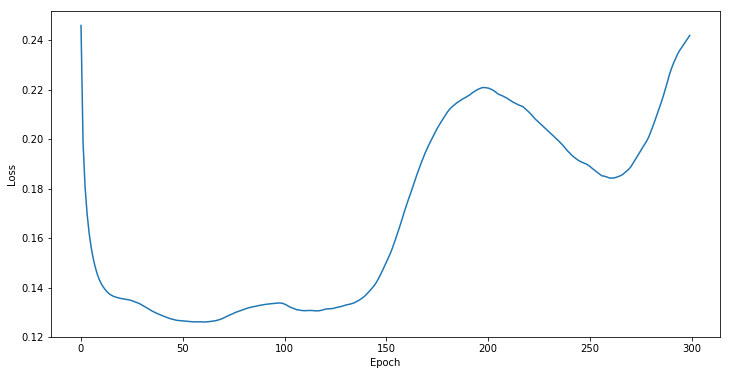

测试集预测准确率: 0.9344


In [12]:
net = Net(train_images.shape[1], cell_num1, cell_num2, cell_num3)
train(net)
draw_loss(loss_list)
accuracy = evaluate(net)
print("测试集预测准确率: {}".format(accuracy))